# Setup - Importing Libraries and Data

In [22]:
import numpy as np
import glob
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [23]:
# Get all Excel files from the raw folder
excel_files = glob.glob('raw/*.xls')
print(excel_files)

excel_file = excel_files[0]

['raw\\11_29_meal_control.xls', 'raw\\11_29_meal_measured.xls', 'raw\\11_29_nv_lounge_control_1.xls', 'raw\\11_29_nv_lounge_measured_1.xls', 'raw\\bc_library_test_rena.xls', 'raw\\nv_lounge_test_zz.xls']


In [24]:
# Read the "List" sheet from the Excel file
df_lists = [pd.read_excel(excel_file, sheet_name='List', index_col="No.", dtype={"Temperature°C": float, "Humidity%RH": float}) for excel_file in excel_files]
for df_list in df_lists:
    df_list.rename(columns={"Temperature°C": "Temperature", "Humidity%RH": "Humidity"}, inplace=True)
    df_list["Time"] = pd.to_datetime(df_list["Time"])

print(len(df_lists))

c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl'

6


In [25]:
date_format = DateFormatter("%H:%M")

def plot_data(time, temp, humidity, marker='.', xlabel=None, ylabel_temp='Temperature (°C)', ylabel_humidity='Humidity (%RH)', title=None):
    fig, ax1 = plt.subplots(1, 2, figsize=(18, 6))

    # Plot temperature
    ax1[0].plot(time, temp, marker=marker)
    ax1[0].set_xlabel(xlabel)
    ax1[0].set_ylabel(ylabel_temp)
    ax1[0].set_title(f'{title} - Temperature')
    ax1[0].grid(True)
    ax1[0].xaxis.set_major_formatter(date_format)

    # Plot humidity
    ax1[1].plot(time, humidity, marker=marker)
    ax1[1].set_xlabel(xlabel)
    ax1[1].set_ylabel(ylabel_humidity)
    ax1[1].set_title(f'{title} - Humidity')
    ax1[1].grid(True)
    ax1[1].xaxis.set_major_formatter(date_format)

    plt.tight_layout()
    plt.show()

# Analysis - Test Dataset

In [26]:
excel_file = [excel_file for excel_file in excel_files if excel_file == "raw\\nv_lounge_test_zz.xls"][0]
test_df = df_lists[excel_files.index(excel_file)]
print(excel_file)

raw\nv_lounge_test_zz.xls


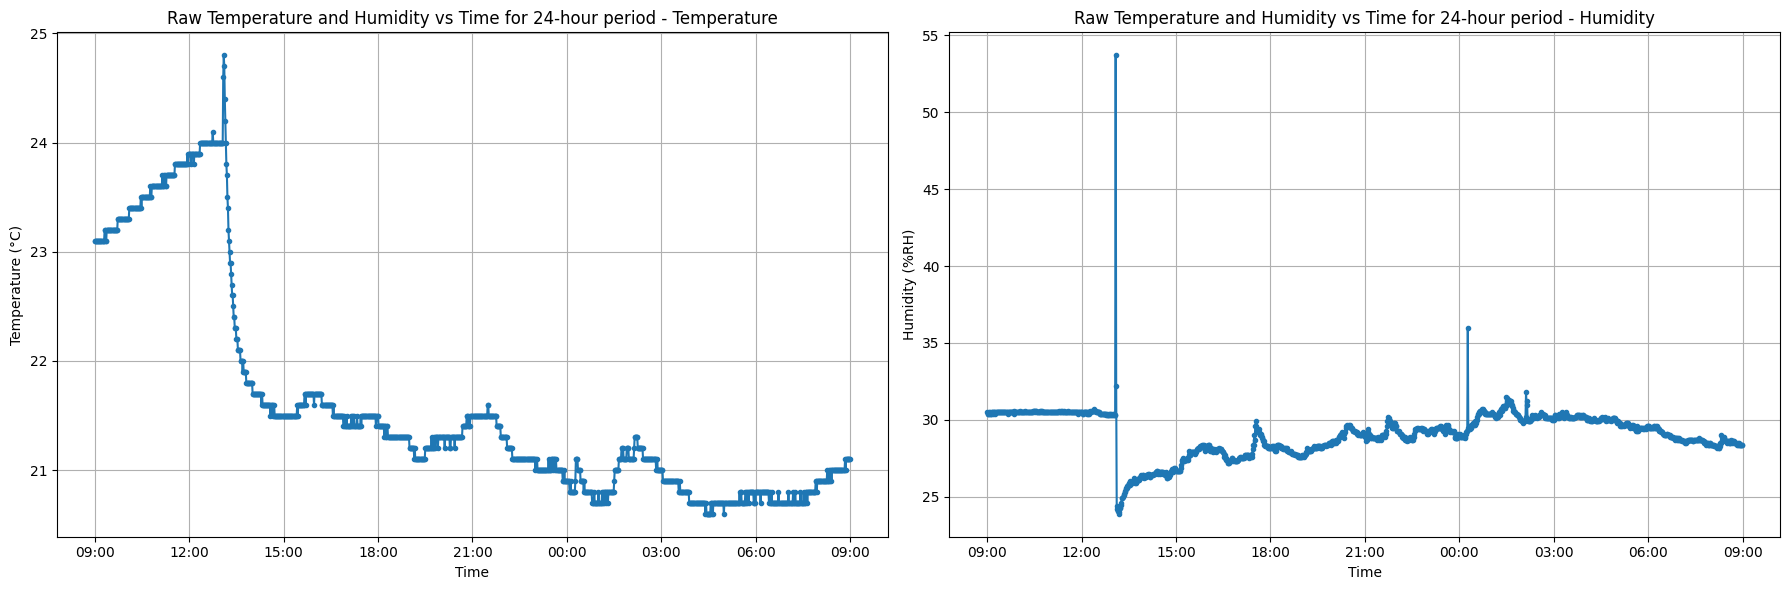

In [27]:
# Filter the dataframe for the 24-hour period from 9am to 9am
start_time = test_df["Time"].iloc[0]
end_time = start_time + pd.Timedelta(hours=24)
df_24h = test_df[(test_df["Time"] >= start_time) & (test_df["Time"] < end_time)]

plot_data(df_24h["Time"], df_24h["Temperature"], df_24h["Humidity"],
          marker='.', xlabel='Time', title='Raw Temperature and Humidity vs Time for 24-hour period')


Data seems noisy, try to remove outliers by IQR method

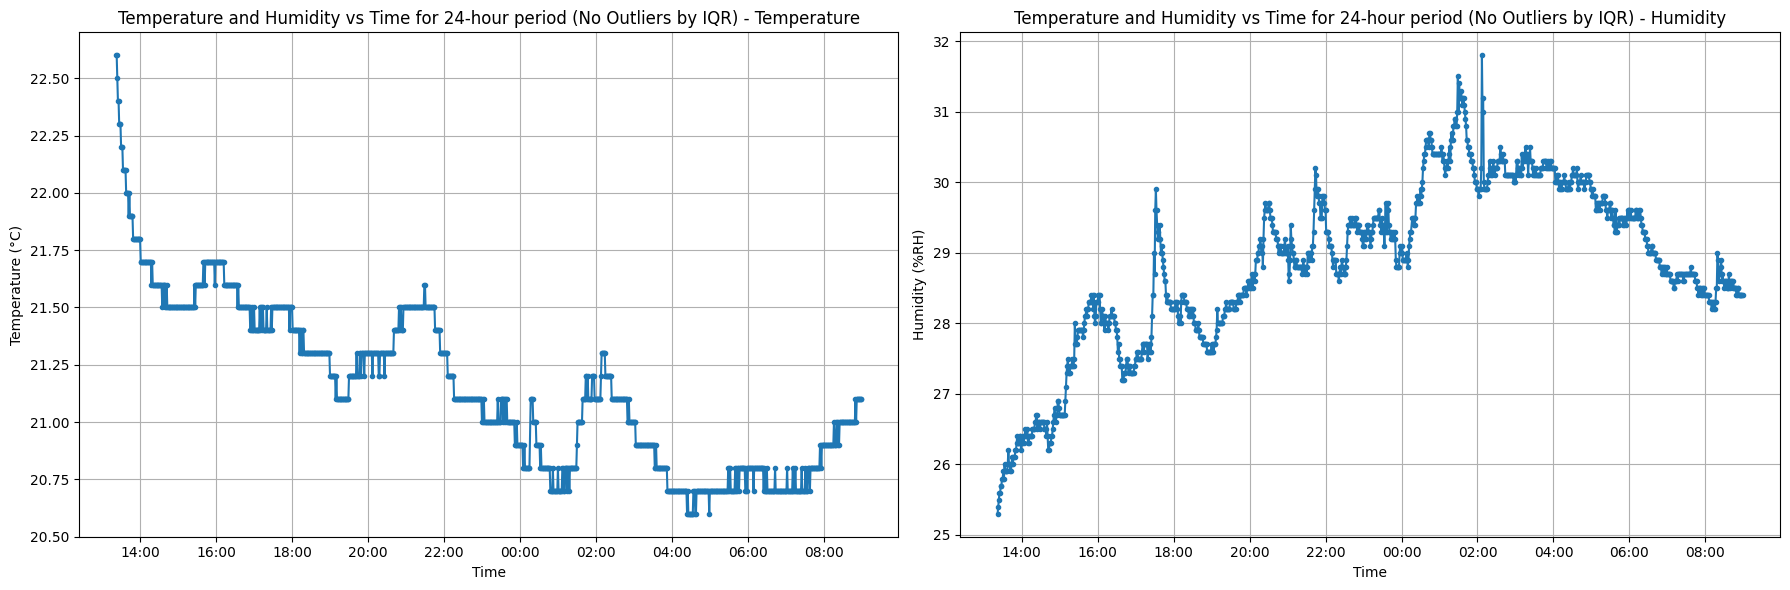

In [28]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Temperature and Humidity
Q1_temp, Q3_temp = df_24h['Temperature'].quantile([0.25, 0.75])
Q1_humidity, Q3_humidity = df_24h['Humidity'].quantile([0.25, 0.75])
IQR_temp = Q3_temp - Q1_temp
IQR_humidity = Q3_humidity - Q1_humidity

# Define outlier criteria for Temperature and Humidity
outlier_criteria_temp = (df_24h['Temperature'] < (Q1_temp - 1.5 * IQR_temp)) | (df_24h['Temperature'] > (Q3_temp + 1.5 * IQR_temp))
outlier_criteria_humidity = (df_24h['Humidity'] < (Q1_humidity - 1.5 * IQR_humidity)) | (df_24h['Humidity'] > (Q3_humidity + 1.5 * IQR_humidity))

# Remove outliers for Temperature and Humidity
df_24h_no_outliers = df_24h[~(outlier_criteria_temp | outlier_criteria_humidity)]

# Plot the temperature and humidity vs time without outliers using the plot_data function
plot_data(df_24h_no_outliers["Time"], df_24h_no_outliers["Temperature"], df_24h_no_outliers["Humidity"],
          marker='.', xlabel='Time', title='Temperature and Humidity vs Time for 24-hour period (No Outliers by IQR)')

Alternatively, filter time series data on a rolling window basis if want less extreme filtering

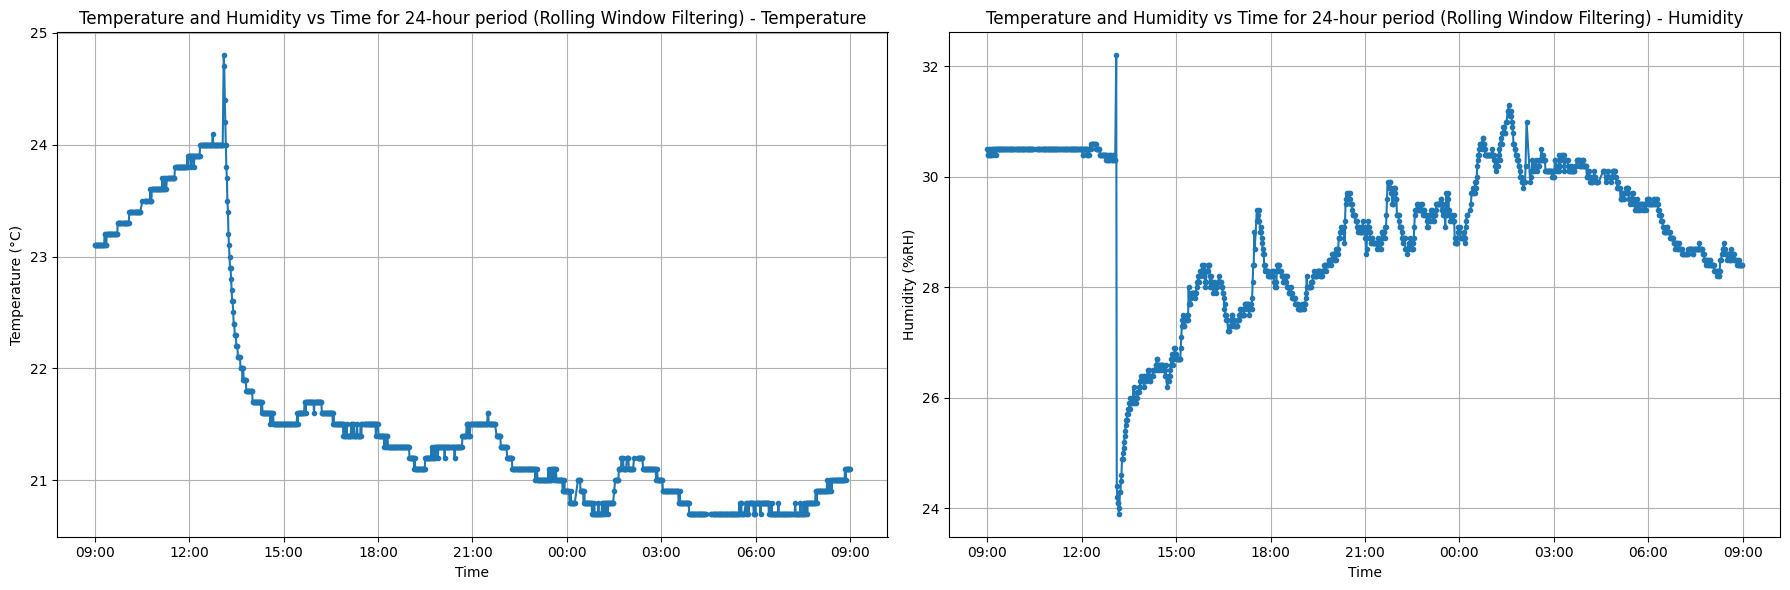

In [29]:
# Define the window size for the rolling statistics
window_size = 60
# Define the threshold for detecting spikes (e.g., 1.96 standard deviations from the mean, 95% CI)
threshold = 1.96

# Calculate the rolling mean and standard deviation for Temperature
rolling_mean_temp = df_24h['Temperature'].rolling(window=window_size, center=True).mean()
rolling_std_temp = df_24h['Temperature'].rolling(window=window_size, center=True).std()

# Calculate the rolling mean and standard deviation for Humidity
rolling_mean_humidity = df_24h['Humidity'].rolling(window=window_size, center=True).mean()
rolling_std_humidity = df_24h['Humidity'].rolling(window=window_size, center=True).std()

# Identify and remove spikes for Temperature
spikes_temp = (df_24h['Temperature'] - rolling_mean_temp).abs() > (threshold * rolling_std_temp)

# Identify and remove spikes for Humidity
spikes_humidity = (df_24h['Humidity'] - rolling_mean_humidity).abs() > (threshold * rolling_std_humidity)

# Remove spikes for both Temperature and Humidity
df_24h_no_spikes = df_24h[~(spikes_temp | spikes_humidity)]

# Plot the temperature and humidity vs time without spikes using the plot_data function
plot_data(df_24h_no_spikes["Time"], df_24h_no_spikes["Temperature"], df_24h_no_spikes["Humidity"],
          marker='.', xlabel='Time', title='Temperature and Humidity vs Time for 24-hour period (Rolling Window Filtering)')


# Analysis - Meal Dataset

raw\11_29_meal_control.xls raw\11_29_meal_measured.xls
996 997
                   Time  Temperature  Humidity
No.                                           
1   2024-11-29 17:40:00         20.6      23.8
2   2024-11-29 17:40:10         20.6      23.8
3   2024-11-29 17:40:20         20.6      23.9
4   2024-11-29 17:40:30         20.6      23.9
5   2024-11-29 17:40:40         20.5      23.9


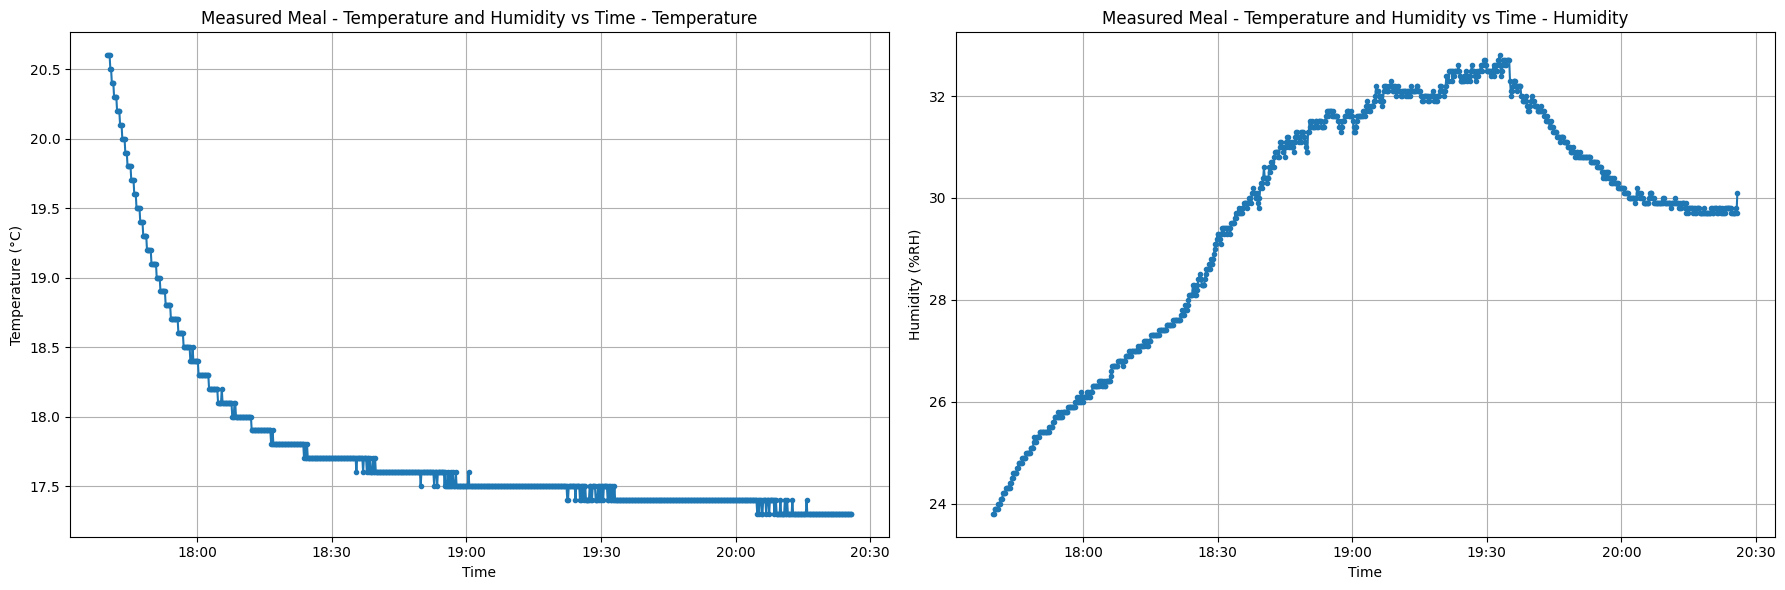

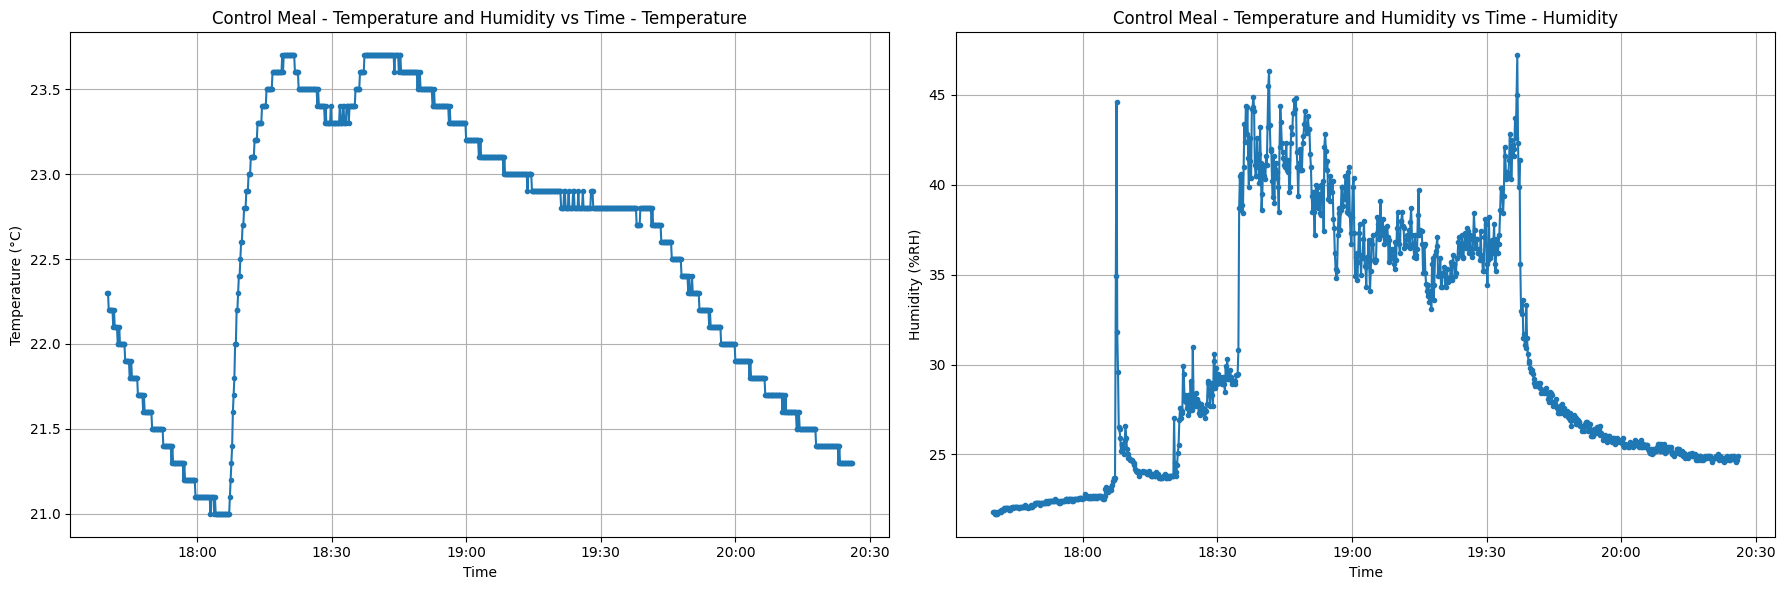

In [33]:
measured_meal, control_meal = [file for file in excel_files if "11_29_meal" in file]
df_measured_meal, df_control_meal = df_lists[excel_files.index(measured_meal)], df_lists[excel_files.index(control_meal)]

print(measured_meal, control_meal)
print(len(df_measured_meal), len(df_control_meal))
print(df_measured_meal.head())

plot_data(df_measured_meal["Time"], df_measured_meal["Temperature"], df_measured_meal["Humidity"],
          marker='.', xlabel='Time', title='Measured Meal - Temperature and Humidity vs Time')

plot_data(df_control_meal["Time"], df_control_meal["Temperature"], df_control_meal["Humidity"],
          marker='.', xlabel='Time', title='Control Meal - Temperature and Humidity vs Time')

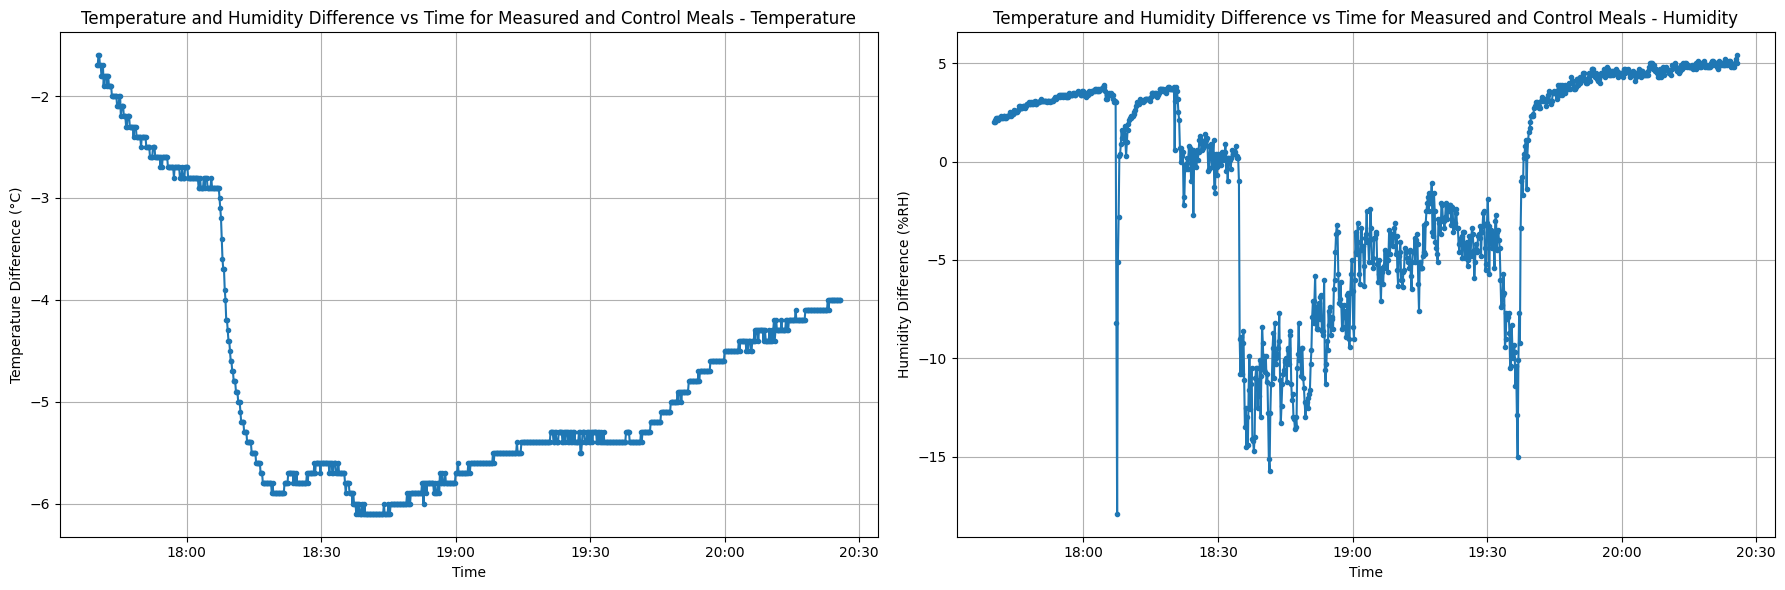

In [34]:
# Merge the dataframes on 'Time' column
df_merged = pd.merge(df_measured_meal, df_control_meal, on='Time', suffixes=('_measured', '_control'))

# Subtract the temperature and humidity data
df_merged['Temperature_diff'] = df_merged['Temperature_measured'] - df_merged['Temperature_control']
df_merged['Humidity_diff'] = df_merged['Humidity_measured'] - df_merged['Humidity_control']

# Select relevant columns and remove rows with NaN values
df_diff = df_merged[['Time', 'Temperature_diff', 'Humidity_diff']].dropna()

# Plot the temperature and humidity difference vs time using the plot_data function
plot_data(df_diff['Time'], df_diff['Temperature_diff'], df_diff['Humidity_diff'],
          marker='.', xlabel='Time', ylabel_temp='Temperature Difference (°C)', ylabel_humidity='Humidity Difference (%RH)',
          title='Temperature and Humidity Difference vs Time for Measured and Control Meals')

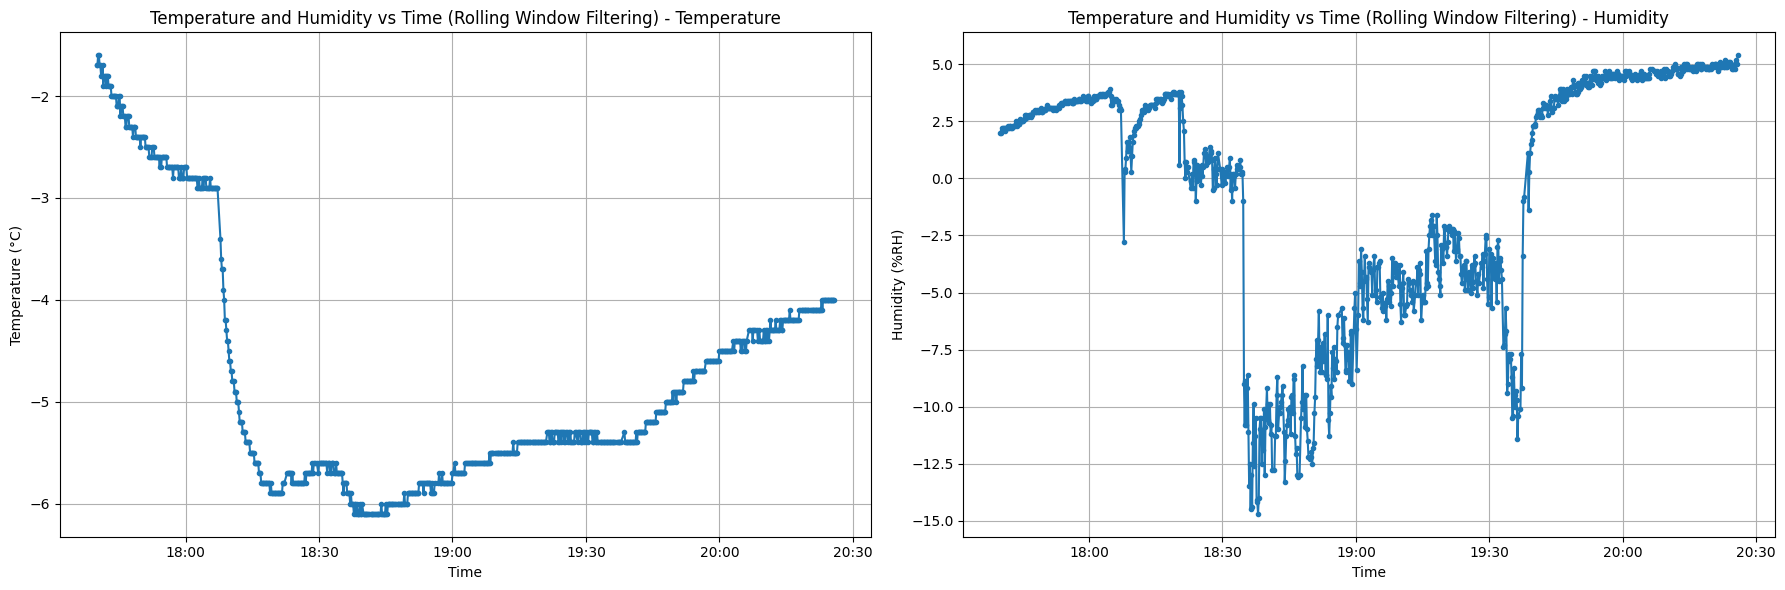

In [35]:
# Define the window size for the rolling statistics
window_size = 60
# Define the threshold for detecting spikes (e.g., 1.96 standard deviations from the mean, 95% CI)
threshold = 1.5

# Calculate the rolling mean and standard deviation for Temperature
rolling_mean_temp_diff = df_diff['Temperature_diff'].rolling(window=window_size, center=True).mean()
rolling_std_temp_diff = df_diff['Temperature_diff'].rolling(window=window_size, center=True).std()

# Calculate the rolling mean and standard deviation for Humidity
rolling_mean_humidity_diff = df_diff['Humidity_diff'].rolling(window=window_size, center=True).mean()
rolling_std_humidity_diff = df_diff['Humidity_diff'].rolling(window=window_size, center=True).std()

# Identify and remove spikes for Temperature
spikes_temp_diff = (df_diff['Temperature_diff'] - rolling_mean_temp_diff).abs() > (threshold * rolling_std_temp_diff)

# Identify and remove spikes for Humidity
spikes_humidity_diff = (df_diff['Humidity_diff'] - rolling_mean_humidity_diff).abs() > (threshold * rolling_std_humidity_diff)

# Remove spikes for both Temperature and Humidity
df_diff_no_spikes = df_diff[~(spikes_temp_diff | spikes_humidity_diff)]

# Plot the temperature and humidity vs time without spikes using the plot_data function
plot_data(df_diff_no_spikes["Time"], df_diff_no_spikes["Temperature_diff"], df_diff_no_spikes["Humidity_diff"],
          marker='.', xlabel='Time', title='Temperature and Humidity vs Time (Rolling Window Filtering)')


Data seems to be off - why does temperature difference go to negative? Probably a callibration error; check if two probes are consistent:

Control Probe             |  Measurement Probe
:-------------------------:|:-------------------------:
![](raw/calibration_control.png)  |  ![](raw/calibration_measured.png)

Probes seem to be consistent for the most part, error seems to be in the probe placement!

1. Place probes at two different places when no people are present and get their difference. This would be the correction factor for the probe placement.
3. Then, one can carry out the actual experiment and correct for the probe placement in this way.

# Analysis - Study Room Dataset